In [45]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

/usr/local/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


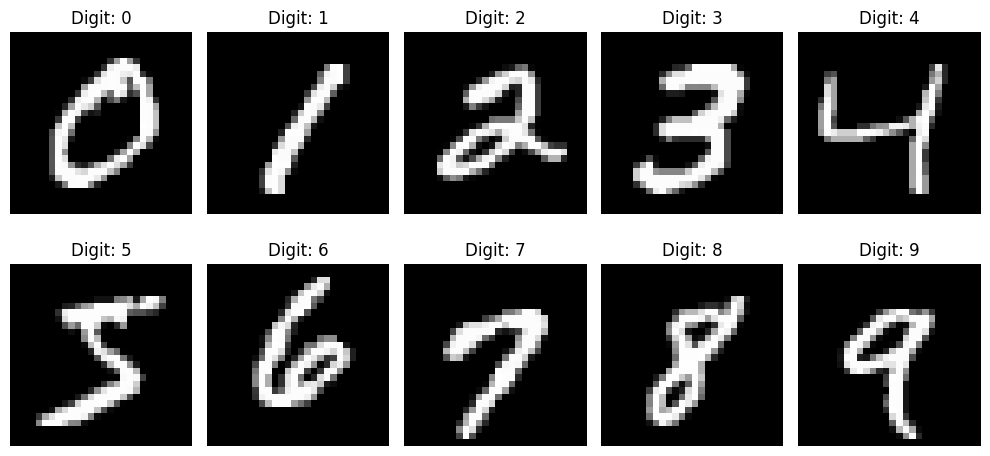

In [46]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
Xraw, Yraw = mnist.data, mnist.target

# Convert Yraw to integers
Yraw = Yraw.astype(int)

# Plot one example of each digit
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(Xraw[Yraw == i].iloc[0].values.reshape(28, 28), cmap='gray')
    ax.set_title(f'Digit: {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [47]:
print(Xraw.shape, Yraw.shape)
Xraw = Xraw.to_numpy()
Yraw = Yraw.to_numpy()

(70000, 784) (70000,)


In [48]:
d = 100
M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
X = M @ Xraw.T

Y = np.zeros((10, Yraw.size))
Y[Yraw, np.arange(Yraw.size)] = 1

print(X.shape, Y.shape)
print(X[0], len(X[0]))
print(Y[0], len(Y[0]))
np.sum(Y[0]), np.sum(Y[:, 0])

(100, 70000) (10, 70000)
[0.56418743 0.6316825  0.41684256 ... 0.58446372 0.55009016 0.87625724] 70000
[0. 1. 0. ... 0. 0. 0.] 70000


(6903.0, 1.0)

In [49]:
W = Y @ np.linalg.pinv(X)
print(W.shape, "\n", W)

(10, 100) 
 [[ 2.99703576e-01  6.39819625e-01  2.99791348e+00  4.23022403e-01
   7.06392741e-01 -5.75415329e-01  1.09515669e-01 -5.54853594e-01
   1.50893433e+00 -8.55005778e-01 -9.69508084e-01 -1.15407048e+00
   1.08751249e+00 -1.37218113e-01 -1.73810445e+00 -7.75024889e-01
   9.84821868e-01 -9.58420444e-02  1.17410507e-01  1.55106532e+00
  -2.31878138e-03  1.71339346e-01  5.48182386e-01 -2.55110246e-01
  -6.00414844e-01  5.69910617e-01  1.15663342e-01 -1.54152530e+00
  -3.91939798e-01  8.60052890e-01 -6.89302888e-01 -6.81784656e-01
   2.87637123e-01  4.77449048e-01  6.76658288e-01  1.40041760e+00
   7.77221588e-01  1.71730536e-01 -3.10503013e-01  9.25814994e-01
  -1.10096069e-01 -3.95615490e-01 -1.05255190e+00 -1.17031169e+00
  -1.75991566e+00 -7.02318136e-01 -1.15089392e+00  9.86786462e-01
  -3.11997960e-01 -2.45578822e+00 -4.86627649e-01 -5.50128024e-01
   1.15109614e+00 -5.86445447e-01 -2.95128733e-01  3.67982306e-01
  -2.02992195e+00  2.15316821e-01 -2.80706027e-02 -8.11406693e-0

In [50]:
d_values = [10, 50, 100, 200, 500]
mse_list = list()
mistakes_list = list()
random_mistakes_list = list()

for d in d_values:
    random_mistakes = 0
    for col in range(Y.shape[1]):
        random_number = np.random.randint(0, 10)
        if random_number != np.argmax(Y[:, col]):
            random_mistakes += 1
    random_mistakes_list.append(random_mistakes)

for d in d_values:
    M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
    X_temp = M @ Xraw.T
    
    W = Y @ np.linalg.pinv(X_temp)
    
    Y_pred = W @ X_temp

    mse = np.mean(np.linalg.norm(Y - Y_pred, axis=0) ** 2)
    mse_list.append(mse)

    mistakes = np.sum(np.argmax(Y, axis=0) != np.argmax(Y_pred, axis=0))
    mistakes_list.append(mistakes)

results = pd.DataFrame({'d': d_values, 'MSE': mse_list, 'Mistakes': mistakes_list, "Random Mistakes": random_mistakes_list})
results.set_index('d', inplace=True)
print(results)

          MSE  Mistakes  Random Mistakes
d                                       
10   0.772059     39312            63062
50   0.538232     15770            63022
100  0.472022     12721            62949
200  0.424542     11082            63093
500  0.394169     10383            63031


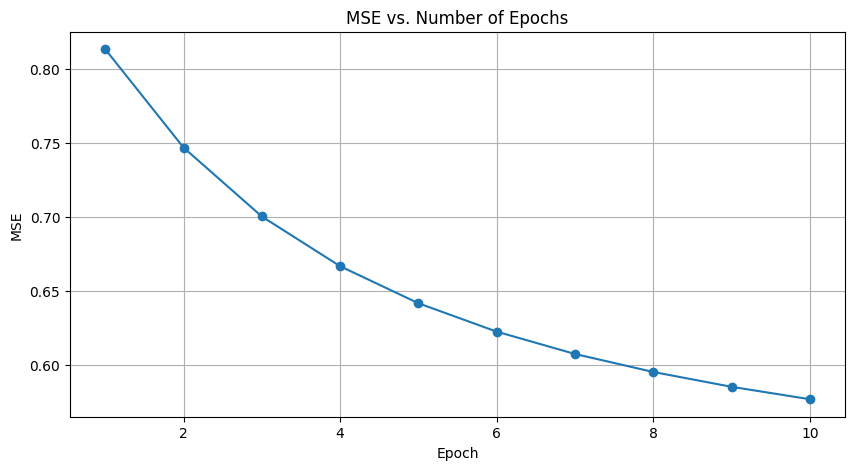

Number of mistakes with LMS algorithm (d=100): 17237
Number of mistakes with exact solution (d=100): 12721


In [51]:
d = 100
eta = 0.001
epochs = 10
mse_lms_list = list()

Y_labels = np.argmax(Y, axis=0)

M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
X_train = M @ Xraw.T

W_lms = np.zeros((len(Y), len(X_train)))

for epoch in range(epochs):
    for i in range(X_train.shape[1]):
        grad = (Y[:, i] - W_lms @ X_train[:, i]).reshape((-1, 1)) @ X_train[:, i].reshape((1, -1))
        W_lms += eta * grad
    
    Y_pred = W_lms @ X_train
    mse_epoch = np.mean(np.linalg.norm(Y - Y_pred, axis=0) ** 2)
    mse_lms_list.append(mse_epoch)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mse_lms_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Epochs')
plt.grid(True)
plt.show()

Y_pred = W_lms @ X_train
mistakes = np.sum(np.argmax(Y, axis=0) != np.argmax(Y_pred, axis=0))

print(f"Number of mistakes with LMS algorithm (d=100): {mistakes}")
print(f"Number of mistakes with exact solution (d=100): {mistakes_list[d_values.index(100)]}")

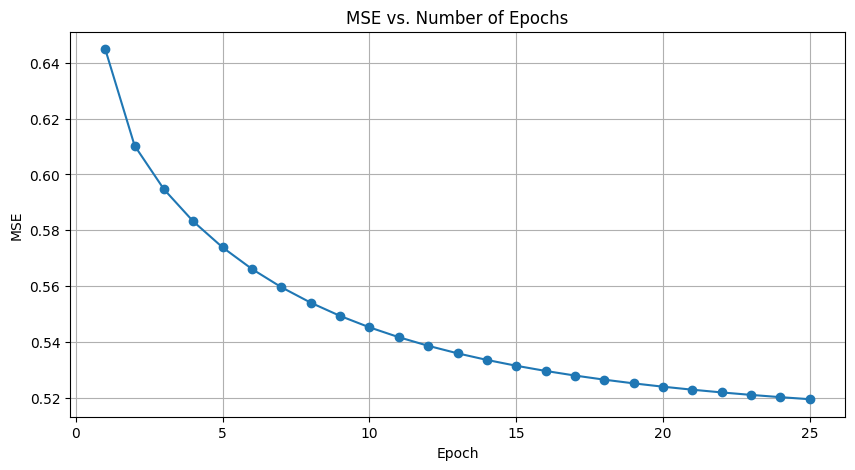

Number of mistakes with LMS algorithm (d=100): 13499
Number of mistakes with exact solution (d=100): 12721


In [52]:
d = 100
eta = 0.01
epochs = 25
mse_lms_list = list()

Y_labels = np.argmax(Y, axis=0)

M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
X_train = M @ Xraw.T

W_lms = np.zeros((len(Y), len(X_train)))

for epoch in range(epochs):
    for i in range(X_train.shape[1]):
        grad = (Y[:, i] - W_lms @ X_train[:, i]).reshape((-1, 1)) @ X_train[:, i].reshape((1, -1))
        W_lms += eta * grad
    
    Y_pred = W_lms @ X_train
    mse_epoch = np.mean(np.linalg.norm(Y - Y_pred, axis=0) ** 2)
    mse_lms_list.append(mse_epoch)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mse_lms_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Epochs')
plt.grid(True)
plt.show()

Y_pred = W_lms @ X_train
mistakes = np.sum(np.argmax(Y, axis=0) != np.argmax(Y_pred, axis=0))

print(f"Number of mistakes with LMS algorithm (d=100): {mistakes}")
print(f"Number of mistakes with exact solution (d=100): {mistakes_list[d_values.index(100)]}")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25


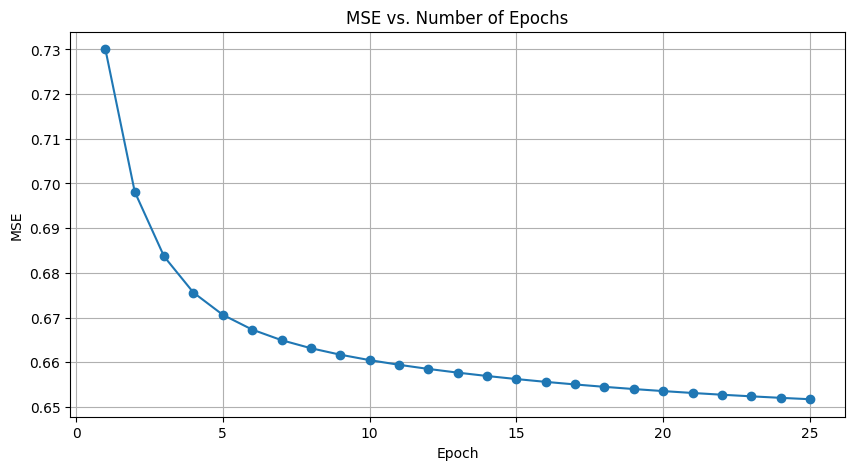

Number of mistakes with LMS algorithm (d=100): 16978
Number of mistakes with exact solution (d=100): 12721


In [53]:
def get_eta(W, grad, x, y):
    return (x.T @ grad.T @ (y - W @ x)) / (x.T @ grad.T @ grad @ x)

d = 100
epochs = 25
etas = list()
mse_lms_list = list()

Y_labels = np.argmax(Y, axis=0)

M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
X_train = M @ Xraw.T

W_lms = np.zeros((len(Y), len(X_train)))

for epoch in range(epochs):
    for i in range(X_train.shape[1]):
        grad = -2 * (Y[:, i] - W_lms @ X_train[:, i]).reshape((-1, 1)) @ X_train[:, i].reshape((1, -1))
        eta = get_eta(W_lms, grad, X_train[:, i], Y[:, i])
        etas.append(eta)
        W_lms += eta * grad
    
    Y_pred = W_lms @ X_train
    mse_epoch = np.mean(np.linalg.norm(Y - Y_pred, axis=0) ** 2)
    mse_lms_list.append(mse_epoch)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mse_lms_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Epochs')
plt.grid(True)
plt.show()

Y_pred = W_lms @ X_train
mistakes = np.sum(np.argmax(Y, axis=0) != np.argmax(Y_pred, axis=0))

print(f"Number of mistakes with LMS algorithm (d=100): {mistakes}")
print(f"Number of mistakes with exact solution (d=100): {mistakes_list[d_values.index(100)]}")